In [1]:
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Add utility path
sys.path.append(str((Path().resolve().parent / "src" / "utils").resolve()))
from load_data import load_csv, save_csv

# -------------------------------
# 📥 Load Raw Data
# -------------------------------
df = load_csv("returns.csv")
df.head()

# -------------------------------
# 🔍 Initial Exploration
# -------------------------------
df.info()
df.isna().sum()
df['reason'].value_counts()


INFO:load_data:✅ CSV loaded: C:\Users\mashel\Desktop\econ_churn\data\raw\returns.csv


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   order_id     100 non-null    object
 1   return_date  100 non-null    object
 2   reason       100 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB


reason
Wrong Item       32
Late Delivery    28
Defective        24
Changed Mind     16
Name: count, dtype: int64

In [3]:

# -------------------------------
# 🧹 Data Cleaning
# -------------------------------

# Convert return_date to datetime
df['return_date'] = pd.to_datetime(df['return_date'], errors='coerce')

# Drop null order_ids or reasons
df = df.dropna(subset=['order_id', 'return_date'])

# Standardize reason text
df['reason'] = df['reason'].str.strip().str.title()

In [9]:
# Load from raw (test)
df_customers = load_csv("customers.csv", source="raw")

INFO:load_data:✅ CSV loaded: C:\Users\mashel\Desktop\econ_churn\data\raw\customers.csv


In [5]:
# -------------------------------
# 🧠 Feature Engineering
# -------------------------------

# Load clean orders to calculate return lag
orders_df = load_csv("orders_clean.csv", source="processed")

# Join with orders to get order_date and net_revenue
returns_merged = df.merge(orders_df[['order_id', 'order_date', 'net_revenue']],
                          on='order_id', how='left')

# Calculate return lag in days
returns_merged['order_date'] = pd.to_datetime(returns_merged['order_date'])
returns_merged['return_lag_days'] = (returns_merged['return_date'] - returns_merged['order_date']).dt.days

# Flag short-lag returns (<7 days)
returns_merged['quick_return'] = returns_merged['return_lag_days'] <= 7

INFO:load_data:✅ CSV loaded: C:\Users\mashel\Desktop\econ_churn\data\processed\orders_clean.csv


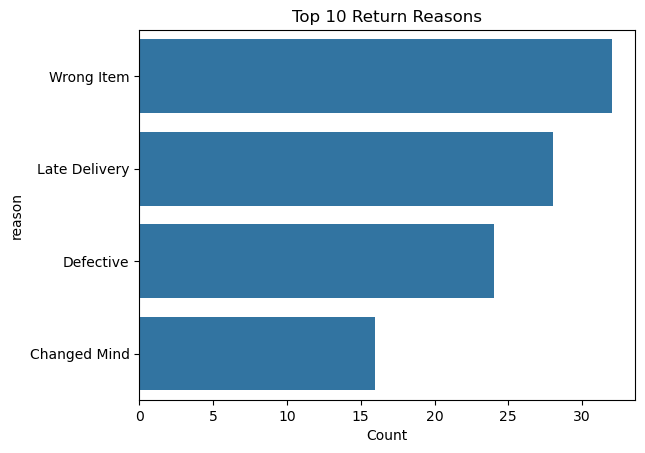

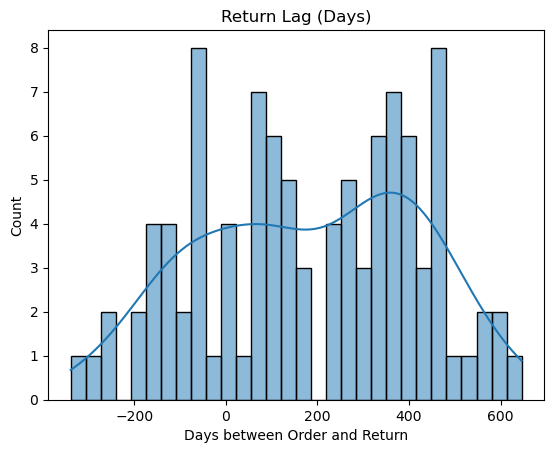

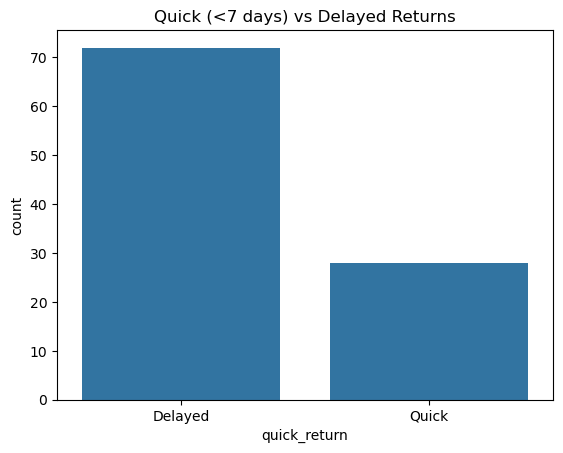

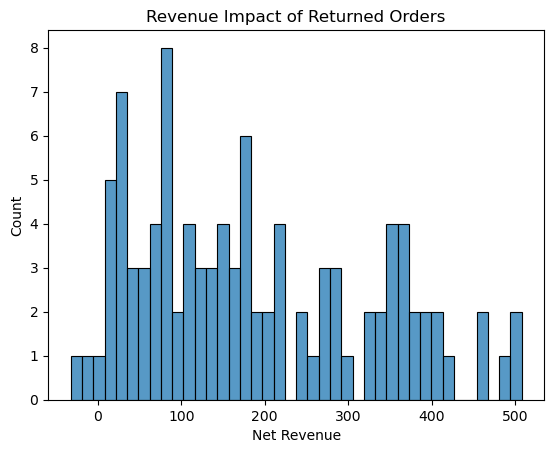

In [6]:
# -------------------------------
# 📊 Exploratory Data Analysis
# -------------------------------

# Top return reasons
top_reasons = returns_merged['reason'].value_counts().nlargest(10)
sns.barplot(y=top_reasons.index, x=top_reasons.values)
plt.title("Top 10 Return Reasons")
plt.xlabel("Count")
plt.show()

# Return lag distribution
sns.histplot(returns_merged['return_lag_days'], bins=30, kde=True)
plt.title("Return Lag (Days)")
plt.xlabel("Days between Order and Return")
plt.show()

# Quick vs delayed returns
sns.countplot(x='quick_return', data=returns_merged)
plt.title("Quick (<7 days) vs Delayed Returns")
plt.xticks([0, 1], ['Delayed', 'Quick'])
plt.show()

# Return impact by revenue
sns.histplot(returns_merged['net_revenue'], bins=40)
plt.title("Revenue Impact of Returned Orders")
plt.xlabel("Net Revenue")
plt.show()


In [7]:
# -------------------------------
# 💾 Save Cleaned File
# -------------------------------
save_csv(returns_merged, "returns_clean.csv")

INFO:load_data:💾 Saved CSV to: C:\Users\mashel\Desktop\econ_churn\data\processed\returns_clean.csv
